In [133]:
import numpy as np
import pandas as pd
from sksurv.datasets import load_veterans_lung_cancer
import matplotlib.pyplot as plt

In [134]:
help(load_veterans_lung_cancer)

Help on function load_veterans_lung_cancer in module sksurv.datasets.base:

load_veterans_lung_cancer()
    Load and return data from the Veterans' Administration
    Lung Cancer Trial
    
    The dataset has 137 samples and 6 features.
    The endpoint is death, which occurred for 128 patients (93.4%).
    
    See [1]_ for further description.
    
    Returns
    -------
    x : pandas.DataFrame
        The measurements for each patient.
    
    y : structured array with 2 fields
        *Status*: boolean indicating whether the endpoint has been reached
        or the event time is right censored.
    
        *Survival_in_days*: total length of follow-up
    
    References
    ----------
    .. [1] Kalbfleisch, J.D., Prentice, R.L.:
        "The Statistical Analysis of Failure Time Data." John Wiley & Sons, Inc. (2002)



# Data

In [135]:
x, y = load_veterans_lung_cancer()
y = np.array(y.tolist())
y # (Survival Status (1/True=Death),  Survival Time)

array([[  1.,  72.],
       [  1., 411.],
       [  1., 228.],
       [  1., 126.],
       [  1., 118.],
       [  1.,  10.],
       [  1.,  82.],
       [  1., 110.],
       [  1., 314.],
       [  0., 100.],
       [  1.,  42.],
       [  1.,   8.],
       [  1., 144.],
       [  0.,  25.],
       [  1.,  11.],
       [  1.,  30.],
       [  1., 384.],
       [  1.,   4.],
       [  1.,  54.],
       [  1.,  13.],
       [  0., 123.],
       [  0.,  97.],
       [  1., 153.],
       [  1.,  59.],
       [  1., 117.],
       [  1.,  16.],
       [  1., 151.],
       [  1.,  22.],
       [  1.,  56.],
       [  1.,  21.],
       [  1.,  18.],
       [  1., 139.],
       [  1.,  20.],
       [  1.,  31.],
       [  1.,  52.],
       [  1., 287.],
       [  1.,  18.],
       [  1.,  51.],
       [  1., 122.],
       [  1.,  27.],
       [  1.,  54.],
       [  1.,   7.],
       [  1.,  63.],
       [  1., 392.],
       [  1.,  10.],
       [  1.,   8.],
       [  1.,  92.],
       [  1.,

In [136]:
x # Covariates

,Age_in_years,Celltype,Karnofsky_score,Months_from_Diagnosis,Prior_therapy,Treatment
0,69.0,squamous,60.0,7.0,no,standard
1,64.0,squamous,70.0,5.0,yes,standard
2,38.0,squamous,60.0,3.0,no,standard
3,63.0,squamous,60.0,9.0,yes,standard
4,65.0,squamous,70.0,11.0,yes,standard
...,...,...,...,...,...,...
132,65.0,large,75.0,1.0,no,test
133,64.0,large,60.0,5.0,no,test
134,67.0,large,70.0,18.0,yes,test
135,65.0,large,80.0,4.0,no,test


# Naive Estimate

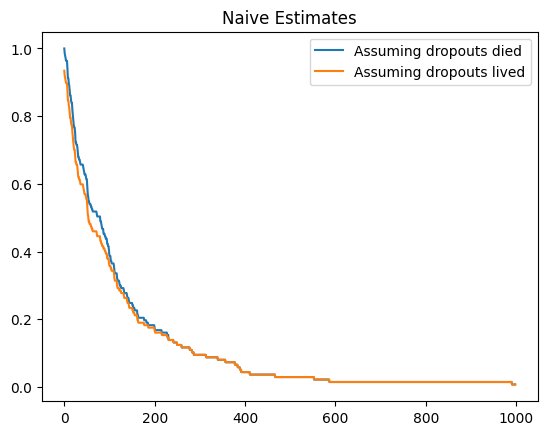

In [137]:
Tmax1 = int(y[:,1].max())
Tmax2 = int(y[y[:,0]==1][:,1].max())

N = len(y)
S1 = np.zeros(Tmax1)
for t in range(Tmax1):
    S1[t] = np.sum(y[:,1] > t)/N 
    
    
Tmax1 = int(y[y[:,0]==1][:,1].max())
N = len(y)
S2 = np.zeros(Tmax2)
for t in range(Tmax2):
    S2[t] = np.sum(y[y[:,0]==1][:,1] > t)/N 

plt.plot(range(Tmax1), S1, label = 'Assuming dropouts died')
plt.plot(range(Tmax2), S2, label = 'Assuming dropouts lived')
plt.title('Naive Estimates')  
plt.legend()
plt.show()

In [138]:
F1 = np.ones(Tmax1) - S1
f = np.zeros(Tmax1)

for t in range(1,Tmax1):
    f[t] = F1[t] - F1[t-1]

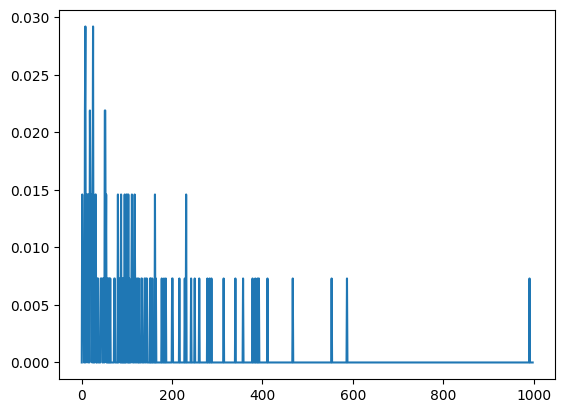

In [139]:
plt.plot(range(Tmax1), f, label = 'Assuming dropouts died')


# Kaplan-Mieir

Text(0.5, 0, 'time $t$')

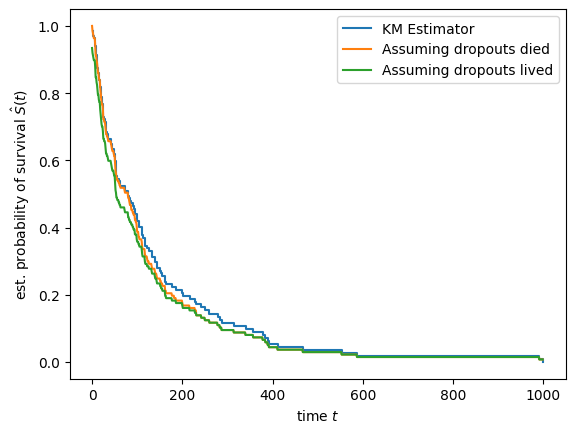

In [140]:
# Kaplan Mieir 
%matplotlib inline
import matplotlib.pyplot as plt
from sksurv.nonparametric import kaplan_meier_estimator
time, survival_prob = kaplan_meier_estimator(y[:,0].astype(bool), y[:,1])
plt.step(time, survival_prob, where="post", label = 'KM Estimator')
plt.plot(range(Tmax1), S1, label = 'Assuming dropouts died')
plt.plot(range(Tmax2), S2, label = 'Assuming dropouts lived')
plt.legend()
plt.ylabel("est. probability of survival $\hat{S}(t)$")
plt.xlabel("time $t$")

# Covariates

In [141]:
x["Treatment"].value_counts()

standard    69
test        68
Name: Treatment, dtype: int64

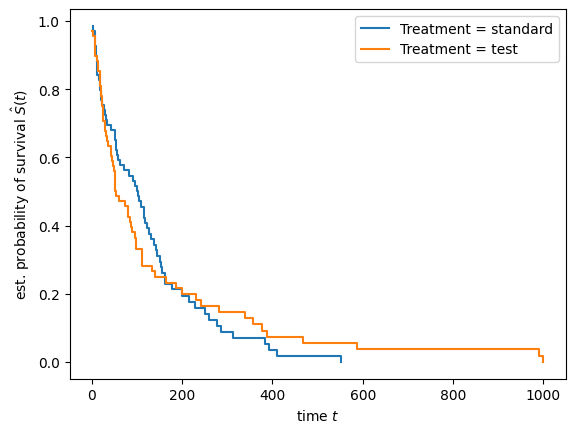

In [142]:
for treatment_type in ("standard", "test"):
    mask_treat = x["Treatment"] == treatment_type
    time_treatment, survival_prob_treatment = kaplan_meier_estimator(y[:,0][mask_treat].astype(bool),y[:,1][mask_treat])
    plt.step(time_treatment, survival_prob_treatment, where="post",label="Treatment = %s" % treatment_type)

plt.ylabel("est. probability of survival $\hat{S}(t)$")
plt.xlabel("time $t$")
plt.legend(loc="best")
plt.show()


In [143]:
x["Celltype"].value_counts()

smallcell    48
squamous     35
adeno        27
large        27
Name: Celltype, dtype: int64

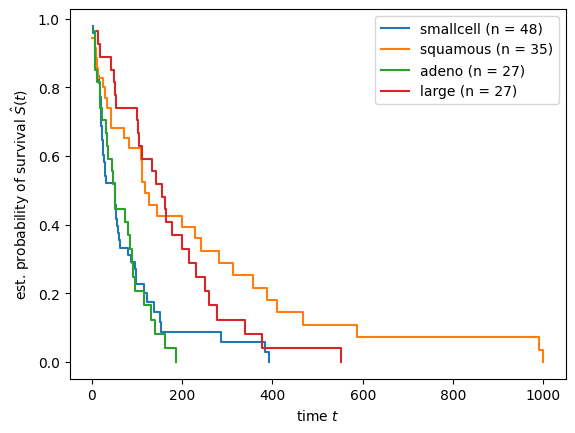

In [144]:
for value in ("smallcell", "squamous", "adeno", "large"):
    mask = x["Celltype"] == value
    time_cell, survival_prob_cell = kaplan_meier_estimator(y[:,0][mask].astype(bool),y[:,1][mask])
    plt.step(time_cell, survival_prob_cell, where="post",label="%s (n = %d)" % (value, mask.sum()))
    
plt.ylabel("est. probability of survival $\hat{S}(t)$")
plt.xlabel("time $t$")
plt.legend(loc="best")
plt.show()

# Proportional Hazards Model

In [145]:
x, y = load_veterans_lung_cancer()
from sksurv.preprocessing import OneHotEncoder
x = OneHotEncoder().fit_transform(x)
x.head()

/usr/local/lib/python3.10/site-packages/sksurv/column.py:142: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for name, series in table.iteritems():


,Age_in_years,Celltype=large,Celltype=smallcell,Celltype=squamous,Karnofsky_score,Months_from_Diagnosis,Prior_therapy=yes,Treatment=test
0,69.0,0.0,0.0,1.0,60.0,7.0,0.0,0.0
1,64.0,0.0,0.0,1.0,70.0,5.0,1.0,0.0
2,38.0,0.0,0.0,1.0,60.0,3.0,0.0,0.0
3,63.0,0.0,0.0,1.0,60.0,9.0,1.0,0.0
4,65.0,0.0,0.0,1.0,70.0,11.0,1.0,0.0


In [147]:
from sklearn import set_config
from sksurv.linear_model import CoxPHSurvivalAnalysis
set_config(display="text")  # displays text representation of estimators
estimator = CoxPHSurvivalAnalysis()
estimator.fit(x, y)
pd.Series(estimator.coef_, index=x.columns) # Log-Hazard Ratios

Age_in_years            -0.008549
Celltype=large          -0.788672
Celltype=smallcell      -0.331813
Celltype=squamous       -1.188299
Karnofsky_score         -0.032622
Months_from_Diagnosis   -0.000092
Prior_therapy=yes        0.072327
Treatment=test           0.289936
dtype: float64

# Prediction

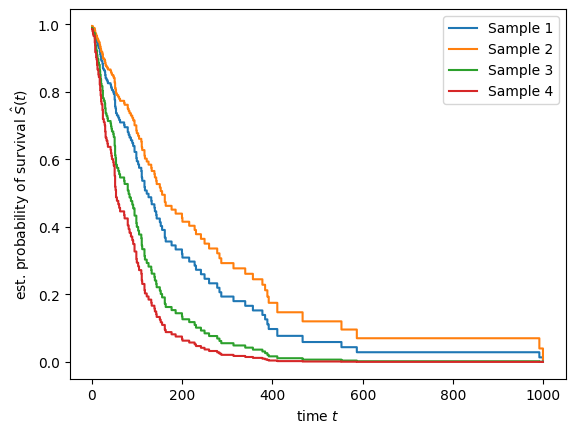

In [150]:
x_new = pd.DataFrame.from_dict({
    1: [65, 0, 0, 1, 60, 1, 0, 1],
    2: [65, 0, 0, 1, 60, 1, 0, 0],
    3: [65, 0, 1, 0, 60, 1, 0, 0],
    4: [65, 0, 1, 0, 60, 1, 0, 1]},
     columns=x.columns, orient='index')

import numpy as np
pred_surv = estimator.predict_survival_function(x_new)
time_points = np.arange(1, 1000)
for i, surv_func in enumerate(pred_surv):
    plt.step(time_points, surv_func(time_points), where="post",
             label="Sample %d" % (i + 1))
plt.ylabel("est. probability of survival $\hat{S}(t)$")
plt.xlabel("time $t$")
plt.legend(loc="best")

# Evaluation

In [152]:
from sksurv.metrics import concordance_index_censored
prediction = estimator.predict(x)
result = concordance_index_censored(y["Status"], y["Survival_in_days"], prediction)
result[0]

0.7362562471603816